## Importing Dataset


In [1]:
import pandas as pd

# Load the dataset
df = pd.read_excel('/content/drive/MyDrive/Imdb.xlsx')

# Display the first 5 rows of the dataframe
display(df.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Exploration

In [2]:
# Check for missing values
print("Missing values per column:")
display(df.isnull().sum())

# Check the distribution of sentiments
print("\nSentiment distribution:")
display(df['sentiment'].value_counts())

# Analyze the length of reviews
df['review_length'] = df['review'].apply(len)
print("\nReview length statistics:")
display(df['review_length'].describe())

Missing values per column:


,0
review,0
sentiment,0



Sentiment distribution:


,count
sentiment,
positive,25000
negative,25000



Review length statistics:


,review_length
count,50000.000000
mean,1309.946840
std,990.682402
min,7.000000
25%,699.000000
50%,971.000000
75%,1591.000000
max,13704.000000


## Data Preprocessing

In [5]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data (if not already downloaded)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Ensure the input is a string
    text = str(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize the text
    tokens = text.split()
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Display the first few cleaned reviews
display(df[['review', 'cleaned_review']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


## Feature Engineering

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
# can adjust parameters like max_features, min_df, max_df, ngram_range
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.9)

# Apply TF-IDF to the cleaned reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (50000, 5000)


In [8]:
# Extract word count
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))

# Extract character count
df['char_count'] = df['cleaned_review'].apply(len)

# Extract average word length
df['average_word_length'] = df['cleaned_review'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

# Display the first few rows with the new features
display(df[['cleaned_review', 'word_count', 'char_count', 'average_word_length']].head())

,cleaned_review,word_count,char_count,average_word_length
0,one reviewer mentioned watching oz episode you...,166,1116,5.728916
1,wonderful little production filming technique ...,84,640,6.630952
2,thought wonderful way spend time hot summer we...,85,572,5.741176
3,basically there family little boy jake think t...,67,443,5.626866
4,petter matteis love time money visually stunni...,125,843,5.752000


## Data Split

In [10]:
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix

# Combine TF-IDF features with additional textual features
# Ensure the additional features are in a sparse format or convert the TF-IDF matrix to dense if needed
additional_features = df[['word_count', 'char_count', 'average_word_length']].values
# Convert to sparse matrix
additional_features_sparse = csr_matrix(additional_features)


X = hstack([tfidf_matrix, additional_features_sparse])
y = df['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000, 5003)
Shape of X_test: (10000, 5003)
Shape of y_train: (40000,)
Shape of y_test: (10000,)


# Model Development

### 1) Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=2000) # Increased max_iter for convergence

# Train the model
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))

Logistic Regression Model Performance:
Accuracy: 0.8862

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Confusion Matrix:
[[4330  631]
 [ 507 4532]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2) Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Multinomial Naive Bayes model
naive_bayes_model = MultinomialNB()

# Train the model
naive_bayes_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = naive_bayes_model.predict(X_test)

# Evaluate the model
print("Multinomial Naive Bayes Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Multinomial Naive Bayes Model Performance:
Accuracy: 0.8252

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.82      0.82      4961
    positive       0.83      0.83      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000


Confusion Matrix:
[[4092  869]
 [ 879 4160]]


### 3) SVM

In [14]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Linear SVM model
linear_svm_model = LinearSVC(max_iter=1000) # You might need to increase max_iter for convergence

# Train the model
linear_svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = linear_svm_model.predict(X_test)

# Evaluate the model
print("Linear SVM Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

Linear SVM Model Performance:
Accuracy: 0.8833

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.88      0.89      0.89      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix:
[[4333  628]
 [ 539 4500]]


### 4) Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Random Forest model
# You might want to adjust n_estimators and other parameters for better performance
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Model Performance:
Accuracy: 0.8522

Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.86      0.85      4961
    positive       0.86      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Confusion Matrix:
[[4264  697]
 [ 781 4258]]


## Model Comparison

In [16]:
import pandas as pd
from sklearn.metrics import classification_report

# Get classification reports for each model
report_logistic = classification_report(y_test, y_pred_logistic, output_dict=True)
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

# Create a dictionary to store the comparison results
comparison_data = {
    'Model': ['Logistic Regression', 'Multinomial Naive Bayes', 'Linear SVM', 'Random Forest'],
    'Accuracy': [report_logistic['accuracy'], report_nb['accuracy'], report_svm['accuracy'], report_rf['accuracy']],
    'Precision (Negative)': [report_logistic['negative']['precision'], report_nb['negative']['precision'], report_svm['negative']['precision'], report_rf['negative']['precision']],
    'Recall (Negative)': [report_logistic['negative']['recall'], report_nb['negative']['recall'], report_svm['negative']['recall'], report_rf['negative']['recall']],
    'F1-score (Negative)': [report_logistic['negative']['f1-score'], report_nb['negative']['f1-score'], report_svm['negative']['f1-score'], report_rf['negative']['f1-score']],
    'Precision (Positive)': [report_logistic['positive']['precision'], report_nb['positive']['precision'], report_svm['positive']['precision'], report_rf['positive']['precision']],
    'Recall (Positive)': [report_logistic['positive']['recall'], report_nb['positive']['recall'], report_svm['positive']['recall'], report_rf['positive']['recall']],
    'F1-score (Positive)': [report_logistic['positive']['f1-score'], report_nb['positive']['f1-score'], report_svm['positive']['f1-score'], report_rf['positive']['f1-score']]
}

# Create a pandas DataFrame for better visualization
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
display(comparison_df)

,Model,Accuracy,Precision (Negative),Recall (Negative),F1-score (Negative),Precision (Positive),Recall (Positive),F1-score (Positive)
0,Logistic Regression,0.8862,0.895183,0.872808,0.883854,0.877784,0.899385,0.888453
1,Multinomial Naive Bayes,0.8252,0.823174,0.824834,0.824003,0.827202,0.825561,0.826381
2,Linear SVM,0.8833,0.889368,0.873413,0.881318,0.877535,0.893034,0.885217
3,Random Forest,0.8522,0.845193,0.859504,0.852289,0.859334,0.845009,0.852111


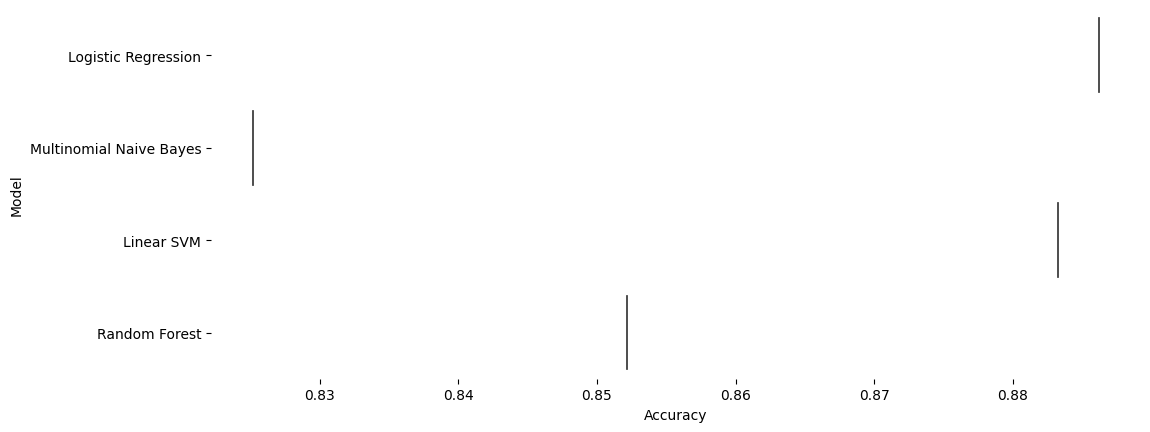

In [26]:
# @title Model vs Accuracy

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

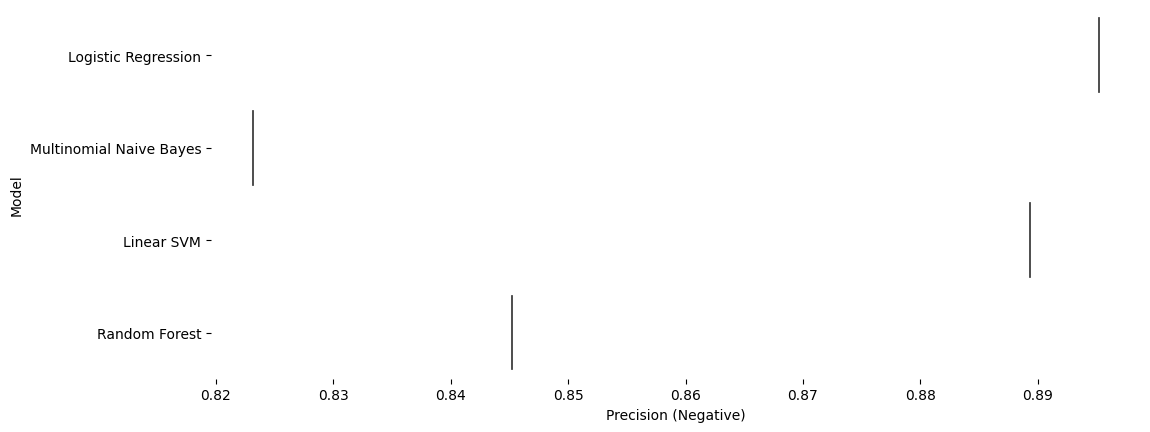

In [25]:
# @title Model vs Precision (Negative)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='Precision (Negative)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

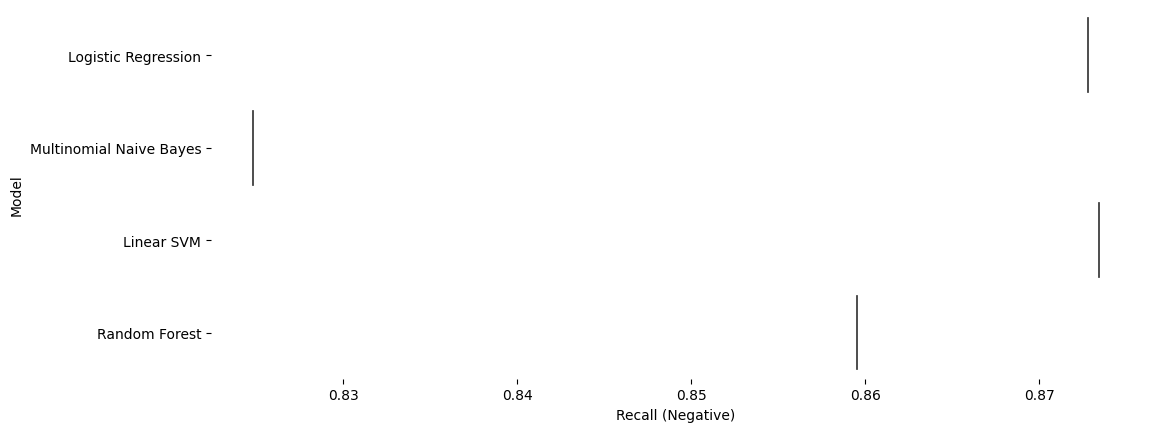

In [24]:
# @title Model vs Recall (Negative)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='Recall (Negative)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

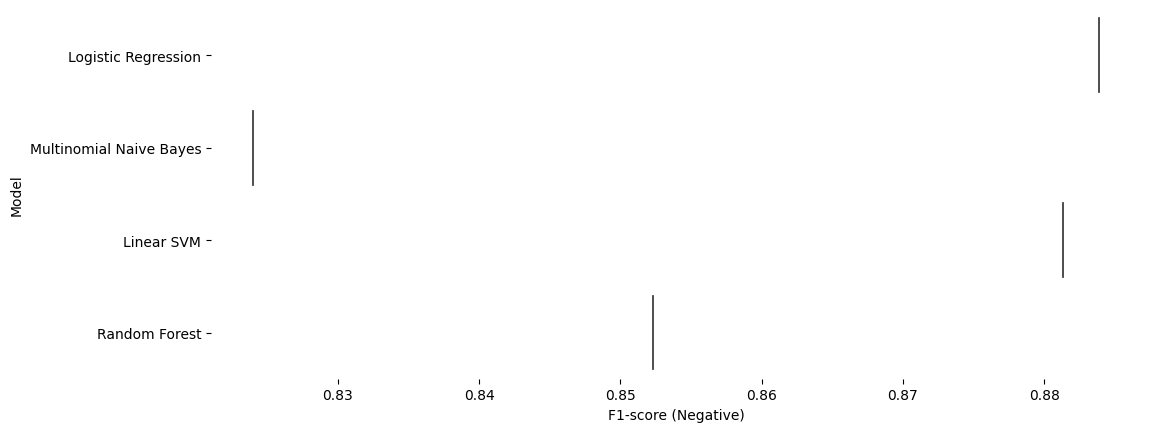

In [23]:
# @title Model vs F1-score (Negative)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(comparison_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(comparison_df, x='F1-score (Negative)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

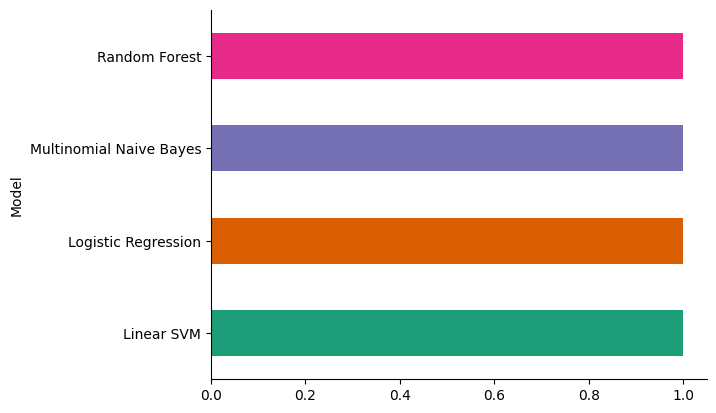

In [22]:
# @title Model

from matplotlib import pyplot as plt
import seaborn as sns
comparison_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid to search
# We can tune parameters like 'C' (regularization strength) and 'solver'
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=2000)

# Initialize GridSearchCV
# cv is the number of cross-validation folds
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
print("Starting GridSearchCV for Logistic Regression...")
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("\nBest parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Get the best model
best_logistic_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best_logistic = best_logistic_model.predict(X_test)

print("\nBest Logistic Regression Model Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_logistic))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_logistic))

Starting GridSearchCV for Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Best parameters found: {'C': 1, 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.8858750000000001

Best Logistic Regression Model Performance on Test Set:
Accuracy: 0.8862

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Confusion Matrix:
[[4330  631]
 [ 507 4532]]


## Final Report Summary: IMDb Movie Review Sentiment Analysis


### 1. Data Loading and Exploration

*   The dataset, `Imdb.xlsx`, was loaded into a pandas DataFrame.
*   Initial exploration revealed:
    *   No missing values in the dataset.
    *   A perfectly balanced distribution of sentiment labels (25,000 positive and 25,000 negative reviews).
    *   Review lengths varied significantly, with an average length of approximately 1310 characters.

### 2. Data Preprocessing

*   The text data in the 'review' column was cleaned and preprocessed to prepare it for model training.
*   Preprocessing steps included:
    *   Removing HTML tags.
    *   Removing non-alphabetic characters and converting text to lowercase.
    *   Tokenization of the text.
    *   Removing common English stop words.
    *   Applying lemmatization to reduce words to their base form.
*   A new column, `cleaned_review`, was added to the DataFrame containing the processed text.

### 3. Feature Engineering

*   Textual data was transformed into numerical features.
*   **TF-IDF Vectorization:**
    *   `TfidfVectorizer` was used to convert the `cleaned_review` text into a matrix of TF-IDF features.
    *   The resulting TF-IDF matrix had a shape of (50000, 5000).
*   **Additional Textual Features:**
    *   Three additional features were extracted: word count, character count, and average word length of the cleaned reviews.
*   The TF-IDF matrix and the additional textual features were combined to form the final feature set (`X`) for model training.

### 4. Data Splitting

*   The combined feature set (`X`) and the sentiment labels (`y`) were split into training and testing sets using `train_test_split`.
*   An 80/20 split was used, with 80% of the data allocated for training and 20% for testing.
*   A `random_state` of 42 was used to ensure reproducibility of the split.
*   The shapes of the resulting sets were:
    *   `X_train`: (40000, 5003)
    *   `X_test`: (10000, 5003)
    *   `y_train`: (40000,)
    *   `y_test`: (10000,)

### 5. Model Development and Evaluation

*   Several classification models were trained and evaluated to predict review sentiment.
*   The performance of each model was evaluated using Accuracy, Precision, Recall, and F1-score.
*   Logistic Regression was the top-performing model based on accuracy and F1-score.

*   **Hyperparameter Tuning (Logistic Regression):**
    *   Hyperparameter tuning was performed on the Logistic Regression model using GridSearchCV.
    *   The best parameters found were `{'C': 1, 'solver': 'lbfgs'}`.
    *   The best cross-validation accuracy was approximately 0.8859.
    *   The tuned Logistic Regression model achieved an accuracy of approximately 0.8862 on the test set, with a classification report and confusion matrix as shown in the output of the tuning cell.

### 6. Conclusion

*   The project successfully built and evaluated several machine learning models for IMDb movie review sentiment analysis.
*   Logistic Regression and Linear SVM demonstrated the best performance among the models tested with the chosen features.
*   Hyperparameter tuning for Logistic Regression resulted in similar performance to the initial model.
*   The models are capable of predicting sentiment with a reasonable degree of accuracy based on the textual content of the reviews.

### 7. Next Steps

*   Further analysis could involve exploring more advanced feature engineering techniques (e.g., word embeddings).
*   Experimenting with deep learning models (e.g., LSTM, BERT) could potentially yield higher accuracy.